<font size="5">ライブラリのインポート

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import math

<font size="5">cpuとgpuの選択

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "gpu")

<font size="5">乱数を特定の値にして再現性を確保

In [3]:
# For reproducibility
torch.manual_seed(42)
if use_cuda:
    torch.cuda.manual_seed(42)

<font size ="5">pytorch用データセットの作成

In [4]:
# Load MNIST dataset
# pytorchではTensorというデータ構造で、モデルの入力、出力、パラメータを表現
# 前処理の定義
"""
これから取得するDatasetの中身がndarray型のデータ集合であるため、前処理でtensor型にしたい

root
Datasetを参照(または保存)するディレクトリを「path」の部分に指定する.
そのディレクトリに取得したいDatasetが存在すればダウンロードせずにそれを使用する.

train
Training用のdataを取得するかどうかを選択する.
FalseにすればTest用のdataを取得するが,この2つの違いはdata数の違いと思ってくれて良い.

download
rootで参照したディレクトリにDatasetがない場合ダウンロードするかどうかを決めることができる.

transform
定義した前処理を渡す.
こうすることでDataset内のdataを参照する時にその前処理を自動で行ってくれる.
"""
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 学習用データとテスト用データの取得
# transformは私用すると前処理を指定できる
# これによりdatasetをdetaloaderに渡して使える状態にした
train_dataset_original = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
print(f"Train Dataset Size: {len(train_dataset_original)}")
test_dataset_original = datasets.FashionMNIST(root='./data', train=False, transform=transform)
print(f"Test Dataset Size: {len(test_dataset_original)}")

Train Dataset Size: 60000
Test Dataset Size: 10000


C:\Users\y9723\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<font size ="5">データの個数を調節

In [5]:
# traindata
# クラス数を取得
num_classes = len(train_dataset_original.classes)
print(num_classes)
print(len(train_dataset_original))
# 各クラスごとのデータ数を計算
desired_class_count = 3000  # 各クラスごとに均等に分割したいデータ数
total_desired_count = desired_class_count * num_classes

# クラスごとに均等にデータを分割するためのリストを作成
selected_indices_1 = []
selected_indices_2 = []

# 各クラスごとに均等にデータを選択
for class_idx in range(num_classes):
    class_indices = np.where(train_dataset_original.targets == class_idx)[0]
    np.random.shuffle(class_indices)
    selected_indices_1.extend(class_indices[:desired_class_count])
    selected_indices_2.extend(class_indices[desired_class_count:2*desired_class_count])

# 選択したデータで新しいデータセットを作成
train_data_1 = torch.utils.data.Subset(train_dataset_original, selected_indices_1)
train_data_2 = torch.utils.data.Subset(train_dataset_original, selected_indices_2)

# # 各クラスごとの新しいデータ数を確認
class_counts_subset_1 = np.bincount([train_dataset_original.targets[i] for i in selected_indices_1])
class_counts_subset_2 = np.bincount([train_dataset_original.targets[i] for i in selected_indices_2])

print("データセット1の各クラスごとの新しいデータ数:", class_counts_subset_1)
print("データセット2の各クラスごとの新しいデータ数:", class_counts_subset_2)

# testdata
# 2. データセット内のクラスごとのサンプル数を確認
class_count = [0] * 10# 10はFashionMNISTのクラス数です
sample_indices = []
for i in range(len(test_dataset_original)):
    _, target = test_dataset_original[i]
    if class_count[target] < 100:  # 各クラスから100サンプルまで抽出
        sample_indices.append(i)
        class_count[target] += 1

# 3. 均等に抽出されたサンプルから新しいデータセットを構築
test_data = torch.utils.data.Subset(test_dataset_original, sample_indices)

# 新しいデータセットを使用して必要な処理を実行

for i in range(len(test_data)):
    if class_count[target] < 100:  # 各クラスから100サンプルまで抽出
        sample_indices.append(i)
        class_count[target] += 1

# 各クラスごとのサンプル数を出力
for i, count in enumerate(class_count):
    print(f"クラス {i}: {count} 個のサンプル")
    
print(f"testデータの数：{len(test_data)}")

10
60000
データセット1の各クラスごとの新しいデータ数: [3000 3000 3000 3000 3000 3000 3000 3000 3000 3000]
データセット2の各クラスごとの新しいデータ数: [3000 3000 3000 3000 3000 3000 3000 3000 3000 3000]
クラス 0: 100 個のサンプル
クラス 1: 100 個のサンプル
クラス 2: 100 個のサンプル
クラス 3: 100 個のサンプル
クラス 4: 100 個のサンプル
クラス 5: 100 個のサンプル
クラス 6: 100 個のサンプル
クラス 7: 100 個のサンプル
クラス 8: 100 個のサンプル
クラス 9: 100 個のサンプル
testデータの数：1000


<font size ="5">Siamese Network用MNISTデータセットクラスの作成

In [6]:
# Siamese Network用MNISTデータセットクラスの作成
class SiameseMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset=dataset
        self.length=len(self.dataset)
        self.pair_index=[]     # Siamese Net用画像ペアインデックス配列
        labels=[label for _, label in self.dataset]     # 入力されたデータセットからラベル情報のみ抽出
        positive_count=0     # positiveペアのカウント
        negative_count=0     # negativeペアのカウント
        random_index=np.arange(self.length)     # ？？？
        
        while positive_count + negative_count < self.length:
            np.random.shuffle(random_index)
            for i in np.arange(self.length):
                if labels[i]==labels[random_index[i]]:     # 画像ペアのラベルが等しい時（positive）
                    if positive_count<self.length/2:      # おそらく比率を同じにしたい？？
                        self.pair_index.append([i, random_index[i], 1])      # 要素の構成：[<画像1のインデックス>,<画像2のインデックス>,<posi:1/nega:0フラグ>]
                        positive_count+=1
                    else:
                        continue
                else:
                    if negative_count<self.length/2:
                        self.pair_index.append([i, random_index[i], 0])
                        negative_count+=1
                    else:
                        continue
#         print("com", self.pair_index)
    def __len__(self):
        return self.length

    def __getitem__(self, index):

        return self.dataset[self.pair_index[index][0]][0], self.dataset[self.pair_index[index][1]][0], torch.tensor(self.pair_index[index][2])

<font size ="5">Siamese Network学習用Dataset, DataLoaderの作成

In [7]:
batch_size=64
# 1 学習用
train_dataset_1=SiameseMNIST(train_data_1) 
train_data_learn=DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
# 2 写像用(領域作成用)
train_data_projection=DataLoader(train_data_2, batch_size=1, shuffle=True)
# 3 テスト用
test_loader=DataLoader(test_dataset_original, batch_size=1, shuffle=True)

<font size ="5">ペア画像の確認

torch.Size([1, 28, 28])
y[0]=1
y[1]=1
y[2]=0
y[3]=1
y[4]=1
y[5]=1
y[6]=1
y[7]=1
y[8]=1
y[9]=1


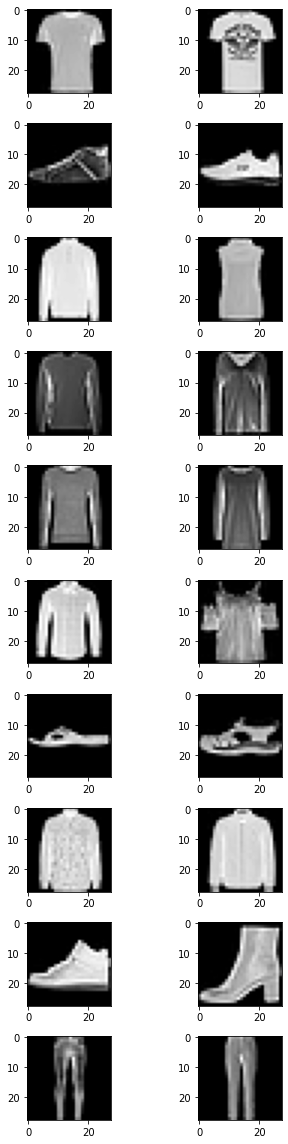

In [8]:
X1, X2, y = next(iter(train_data_learn))
print(X1[0].shape)
fig=plt.figure(tight_layout=True, figsize=(8, 16))
rows=10
for i in range(rows):
    print(f"y[{i}]={y[i]}")
    ax = fig.add_subplot(rows, 2, i*2+1)
    ax.imshow(X1[i][0].numpy(), cmap='gray')                          # X1[i].shape = (1, 28, 28)，X1[i][0].shape = (28, 28)
    ax = fig.add_subplot(rows, 2, i*2+2)
    ax.imshow(X2[i][0].numpy(), cmap='gray') 

<font size="5">モデルの構築

super()はあるクラス（子クラス）で別のクラス（親クラス）を継承できる。継承することで、親クラスのメソッドを子クラスから呼び出すことができる。
以下の形式
super().親クラスのメソッド

In [9]:
class BaseNetwork(nn.Module):
    """
    Base network for Siamese Network.
    This will be shared between two input images.
    """
    def __init__(self):
        super().__init__()

        # Define the layers
        # Using similar architecture as in the Keras example

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten and Dense Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Assuming input image size is 28x28
        self.act3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 256)
        self.act4 = nn.ReLU()

    def forward_1(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.dropout(x)
        x = self.fc2(x)
#         print("xのshape",x)
        x = self.act4(x)

        return x

    def forward(self, x1,x2):
        z1=self.forward_1(x1)
        z2=self.forward_1(x2)
        return z1,z2

# Test the base network with a sample input
base_network = BaseNetwork().to(device)
sample_input = torch.randn(8, 1, 28, 28).to(device)  # Batch of 8 images of sizammm28x28 with 1 channel
sample_output = base_network.forward_1(sample_input)

sample_output.shape  # Expected: [8, 256]


C:\Users\y9723\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([8, 256])

In [10]:
# Siamse Networkモデルクラス
import torch.nn as nn

class SiameseCNNMnistModel(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2), # 28x28x32
            nn.ReLU(),
            nn.MaxPool2d(2,2),                         # 14x14x32
            nn.Conv2d(32, 64, kernel_size=5, padding=2),# 14x14x64
            nn.ReLU(),
            nn.MaxPool2d(2,2)                          # 7x7x64
        )

        # Fully connected layers to get embeddings
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )
    
    def forward_once(self, x):
        x = self.encoder(x)
        x = x.view(x.size()[0], -1)  # Flatten
        z = self.fc(x)
        return z
  
    def forward(self, x1, x2):
        z1 = self.forward_once(x1)
        z2 = self.forward_once(x2)
        return z1, z2


<font size="5">損失関数

In [11]:
# 損失関数
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z1, z2, y):
        difference = z1 - z2
        distance_squared = torch.sum(torch.pow(difference, 2), 1)
        distance = torch.sqrt(distance_squared)       #平均：0.813，最大：1.663，最小：0.023，中央値：0.492
        negative_distance = self.margin - distance
        negative_distance = torch.clamp(negative_distance, min=0.0)
        loss = (abs(y) * distance_squared + (1 - (y)) * torch.pow(negative_distance, 2)) / 2.0
        loss = torch.sum(loss) / z1.size()[0]
        return loss

<font size ="5">使用関数の一覧実行

In [12]:
# 重心を算出
def caluc_cluster(data, labels, i, class_num):
    x_1 = np.mean(data[labels==i, 0], axis=0)
    y_1 = np.mean(data[labels==i, 1], axis=0)
    z_1 = np.mean(data[labels==i, 2], axis=0)
    centroids=(x_1, y_1, z_1)
#     print("ラベル", i, "の重心：", x_1, y_1, z_1)
    return centroids

# 単位球面上に写像する関数
def norm(data):
    norm_data=data.copy()
    for i in range(len(data)):
        norm_data[i]=data[i] / np.linalg.norm(data[i], ord=2)
    return norm_data


def caluc_rotation_main(data):
    # 値の入力
    x=data[0, 0]
    y=data[0, 1]
    z=data[0, 2]
    
    # xの回転
    theta_1 = np.arctan2(y, z)
    
    x_rot_0 = x
    x_rot_1 = y*np.cos(theta_1) - z*np.sin(theta_1)
    x_rot_2 = y*np.sin(theta_1)+z*np.cos(theta_1)
    
    # 値の更新
    x=x_rot_0
    y=x_rot_1
    z=x_rot_2
    
    # yの回転
    theta_2 = np.arctan2(-x, z)
    
    y_rot_0 = x*np.cos(theta_2) + z*np.sin(theta_2)
    y_rot_1 = y
    y_rot_2 = -x*np.sin(theta_2) + z*np.cos(theta_2)
    
    ans=(y_rot_0, y_rot_1, y_rot_2)
    theta=theta_1, theta_2
    
    return ans, theta

def caluc_rotation_sub(data, theta):
    ans=np.zeros((9,3))
    for i in range(1,data.shape[0]):
        # 値の入力
        x=data[i, 0]
        y=data[i, 1]
        z=data[i, 2]

        # xの回転
        theta_1 = theta[0]

        x_rot_0 = x
        x_rot_1 = y*np.cos(theta_1) - z*np.sin(theta_1)
        x_rot_2 = y*np.sin(theta_1)+z*np.cos(theta_1)

        # 値の更新
        x=x_rot_0
        y=x_rot_1
        z=x_rot_2

        # yの回転
        theta_2 = theta[1]

        y_rot_0 = x*np.cos(theta_2) + z*np.sin(theta_2)
        y_rot_1 = y
        y_rot_2 = -x*np.sin(theta_2) + z*np.cos(theta_2)
        print(i)
        ans[i-1]=(y_rot_0, y_rot_1, y_rot_2)
    
    return ans

def caluc_rotation_data(data, theta):
    ans=np.zeros((data.shape[0],data.shape[1]))
#     print(ans.shape)
    for i in range(data.shape[1]):
        # 値の入力
        x=data[:, 0]
        y=data[:, 1]
        z=data[:, 2]

        # xの回転
        theta_1 = theta[0]

        x_rot_0 = x
        x_rot_1 = y*np.cos(theta_1) - z*np.sin(theta_1)
        x_rot_2 = y*np.sin(theta_1)+z*np.cos(theta_1)

        # 値の更新
        x=x_rot_0
        y=x_rot_1
        z=x_rot_2

        # yの回転
        theta_2 = theta[1]

        y_rot_0 = x*np.cos(theta_2) + z*np.sin(theta_2)
        y_rot_1 = y
        y_rot_2 = -x*np.sin(theta_2) + z*np.cos(theta_2)
        ans=(y_rot_0, y_rot_1, y_rot_2)
        
    
    return ans


<font size ="5">学習の準備

In [13]:
import torch.optim as optim
from torchsummary import summary

#モデルのインスタンス化
model=SiameseCNNMnistModel().to(device)
print(model.parameters)
# ？？？？
summary(model, input_size=[(1, 28, 28), (1, 28, 28)])      # 入力が２つあるので（ペア画像だから）input_sizeはリストで複数指定する

# 最適化関数の定義
optimizer=optim.SGD(model.parameters(), lr=0.05)

# 損失関数のインスタンス化
criterion=ContrastiveLoss()

<bound method Module.parameters of SiameseCNNMnistModel(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              

<font size ="5">学習の実行

epoch=0



nan/normal: 3/466
epoch=1



nan/normal: 3/466
epoch=2



nan/normal: 3/466
epoch=3



nan/normal: 3/466
epoch=4



nan/normal: 3/466
epoch=5



nan/normal: 3/466
epoch=6



nan/normal: 3/466
epoch=7



nan/normal: 3/466
epoch=8



nan/normal: 3/466
epoch=9



nan/normal: 3/466
epoch=10



nan/normal: 3/466
epoch=11



nan/normal: 3/466
epoch=12



nan/normal: 3/466
epoch=13



nan/normal: 3/466
epoch=14



nan/normal: 3/466
epoch=15



nan/normal: 3/466
epoch=16



nan/normal: 3/466
epoch=17



nan/normal: 3/466
epoch=18



nan/normal: 3/466
epoch=19



nan/normal: 3/466
epoch=20



nan/normal: 3/466
epoch=21



nan/normal: 3/466
epoch=22



nan/normal: 3/466
epoch=23



nan/normal: 3/466
epoch=24



nan/normal: 3/466
epoch=25



nan/normal: 3/466
epoch=26



nan/normal: 3/466
epoch=27



nan/normal: 3/466
epoch=28



nan/normal: 3/466
epoch=29



nan/normal: 3/466
epoch=30



nan/normal: 3/466
epoch=31



nan/normal: 3/466
epoch=32



nan/normal: 3/466
epoch=33



nan/normal: 3/466
epoch=34



nan/normal: 3/466
epoch=35



nan/normal: 3/466
epoch=36



nan/normal: 3/466
epoch=37



nan/normal: 3/466
epoch=38



nan/normal: 3/466
epoch=39



nan/normal: 3/466


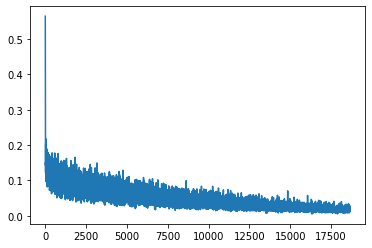

In [14]:
import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# モデル学習
repeat = 40                                                      # 学習回数
losses = []                                                       # 表示用損失値配列

model.train()                                                     # 学習モード
for epoch in range(repeat): 
  print(f"epoch={epoch}")
  nan_count = 0
  normal_count = 0

  # tqdmを使って学習の進行状況を表示
  for X1, X2, y in tqdm(train_data_learn, desc=f"Epoch {epoch+1}/{repeat}"):                                  
    # モデルによる特徴ベクトル算出
    output1, output2 = model(X1.to(device), X2.to(device))

    # 損失関数の計算
    loss = criterion(output1, output2, y.to(device))

    # nan対策（lossにnanが含まれていれば１回前のモデルに戻す）
    if torch.isnan(loss):
      model = prev_model
      optimizer = optim.SGD(model.parameters(), lr=0.05)
      optimizer.load_state_dict(prev_optimizer.state_dict())
      nan_count += 1
      continue
    else:
      prev_model = copy.deepcopy(model)
      prev_optimizer = copy.deepcopy(optimizer)
      normal_count += 1

    # 表示用lossデータの記録
    losses.append(loss.item())

    # 勾配を初期化
    optimizer.zero_grad()
    
    # 損失関数の値から勾配を求め誤差逆伝播による学習実行
    loss.backward()
    
    # 学習結果に基づきパラメータを更新
    optimizer.step()

  print(f"nan/normal: {nan_count}/{normal_count}")
plt.plot(losses)                                                  # loss値の推移を表示


<font size ="5">学習結果の保存

In [15]:
torch.save(model.state_dict(), 'model_weights.pth')

<font size ="5">学習済みの重みを再利用する場合

In [16]:
# model.load_state_dict(torch.load('model_weights.pth''))

<font size ="5">モデルの出力ベクトルの取得

モデル学習の結果、同じクラスに属する画像の出力ベクトルは近くに、異なる数字に属する画像の出力ベクトルは遠くに配置されているはず。
これを確認するために、テストデータを用いて出力ベクトルを集める。
model.eval()で評価モードに設定し、変数の勾配も再計算されないようにtorch.no_grid()を記述する。

In [17]:
# モデル評価
model.eval()                                                      # 評価モード
with torch.no_grad():
    z_valid = []
    y_valid = []
    for X, y in train_data_projection:                                      # テスト用DataLoader
        z_valid.append(model.forward_once(X.to(device)))           # テストデータをモデルに通して出力ベクトルを得る
        y_valid.append(y)                                          # ラベル（靴、シャツ）の代わりにラベルIDとして0～9の数代わり振られている
    z_valid = torch.cat(z_valid, dim=0)                             # 多次元torch.tensor要素のリストをtorch.tensor化
    y_valid = torch.tensor(y_valid)                                 # スカラ要素(int)リストをtorch.tensor化

In [18]:
# model(train_loader_learn)

In [19]:
# 次元数の確認
print(z_valid.size())
print(y_valid.size())

torch.Size([30000, 3])
torch.Size([30000])


z_testとy_testをGPUに移動

In [20]:
# GPUが利用可能かチェック
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# z_validとy_validをGPUに移動
z_valid = z_valid.to(device)
y_valid = y_valid.to(device)
# ndarrayに変換
z_valid_np = z_valid.to('cpu').detach().numpy().copy()
y_valid_np = y_valid.to('cpu').detach().numpy().copy()
print(z_valid_np.shape)
print(y_valid_np.shape)

(30000, 3)
(30000,)


<font size="5">モデル出力ベクトルの分布可視化

<IPython.core.display.Javascript object>


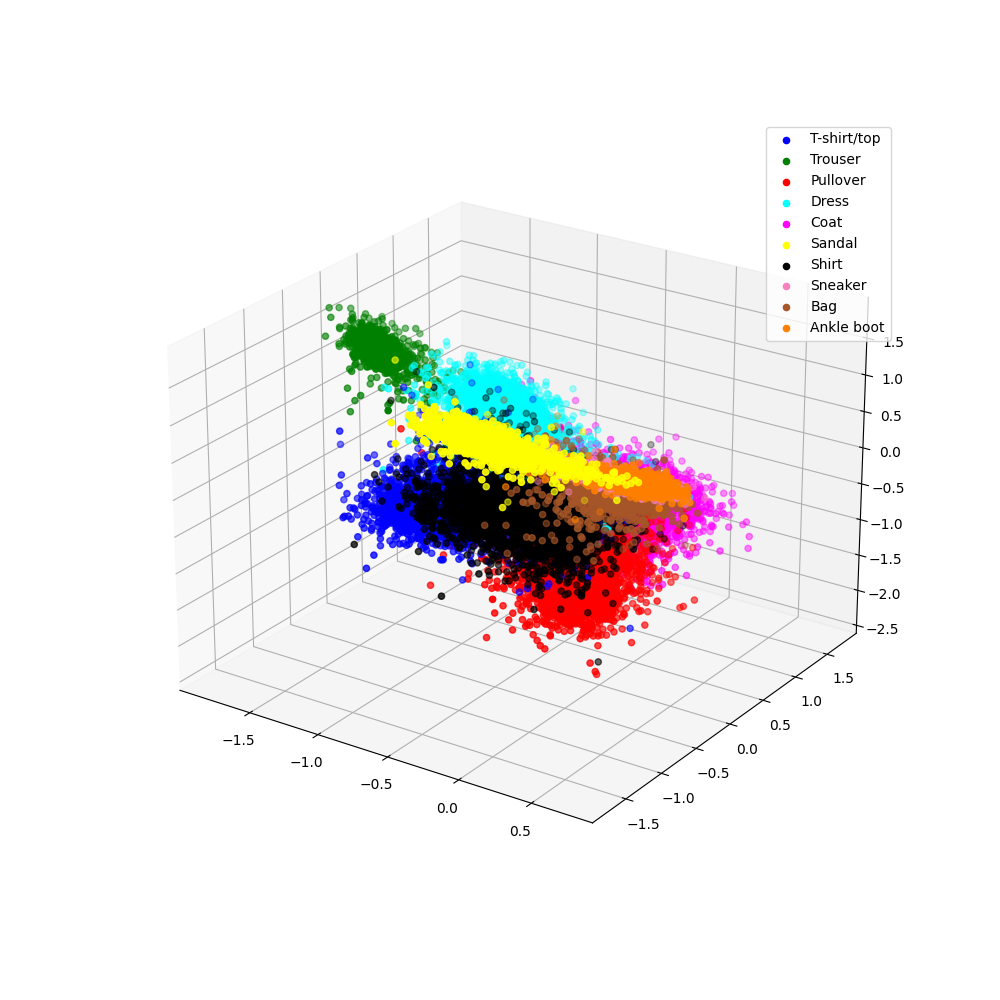

In [25]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# クラス名
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# クラス数
class_num=len(class_names)
# 事前に定義された10色のリスト
colors = ["blue","green","red","cyan","magenta","yellow","black",'#f781bf','#a65628','#ff7f00']
# figureを生成する
plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = plt.subplot(111, projection='3d')
# クラスごとに色を分けてプロット
for i in range(class_num):
    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i])
ax.legend()  # 凡例の追加
plt.show()

<IPython.core.display.Javascript object>


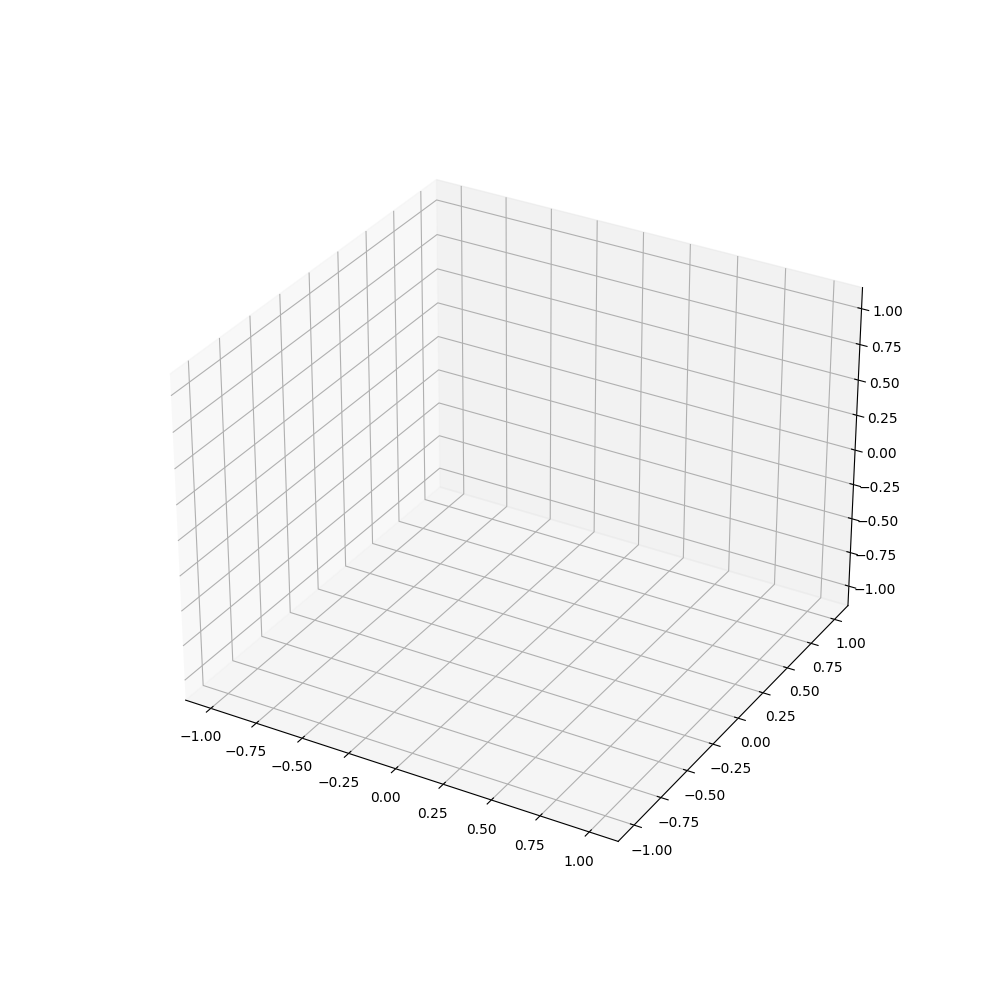

1
2
3
4
5
6
7
8
9
[[ 0.00000000e+00  5.55111512e-17  1.00000000e+00]
 [-7.42803556e-01  5.04940079e-01  4.39634387e-01]
 [ 4.38497160e-01 -7.45824021e-01  5.01464625e-01]
 [-8.61474780e-01 -2.66894712e-01  4.32005112e-01]
 [-1.47373439e-01 -9.77281425e-01  1.52322308e-01]
 [-1.15983632e-01  9.88630482e-01  9.56951838e-02]
 [ 1.54384791e-02 -5.58747766e-01  8.29193938e-01]
 [ 8.87763443e-02  8.67646806e-01 -4.89190945e-01]
 [ 1.75147544e-01  8.11231439e-01 -5.57877129e-01]
 [ 1.03972557e-01  8.11048945e-01 -5.75664239e-01]]


In [22]:
%matplotlib notebook

# 球体のパラメータ
radius = 1
phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
phi, theta=np.meshgrid(phi, theta)

# 球体の座標を計算
x = radius * np.sin(phi) * np.cos(theta)
y = radius * np.sin(phi) * np.sin(theta)
z = radius * np.cos(phi)


# figureを生成する
fig=plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = fig.add_subplot(111, projection='3d')
# 球体をプロット
ax.plot_surface(x, y, z, linewidth=1, edgecolor=(0.8, 0.8, 0.8, 1.0), alpha=0)

# 重心格納用のリスト
centroids=np.zeros((class_num, 3))

# 詳細の処理

# 重心の算出
for i in range(class_num):
    centroids[i]=caluc_cluster(z_valid_np, y_valid_np, i, class_num)
# 単位球上へ写像
norm_data=norm(z_valid_np)
norm_centroids=norm(centroids)
# データの回転
rotate_centroids_1, theta = caluc_rotation_main(norm_centroids)
rotate_centroids_other = caluc_rotation_sub(norm_centroids, theta)
# ansを合体させる
rotate_centroids=np.zeros((10, 3))
rotate_centroids[0]=rotate_centroids_1
rotate_centroids[1:]=rotate_centroids_other
print(rotate_centroids)
# 他dataの回転→data_projectionの作成
new_data=caluc_rotation_data(norm_data, theta)
data_projection = np.array(new_data, dtype=float)
data_projection=np.transpose(data_projection)

# クラスごとに色を分けてプロット
for i in range(class_num):
    ax.scatter(data_projection[y_valid_np==i, 0], data_projection[y_valid_np==i, 1], data_projection[y_valid_np==i, 2], color=colors[i], label=class_names[i])
    ax.scatter(rotate_centroids[i, 0], rotate_centroids[i, 1], rotate_centroids[i, 2], marker='*', color=colors[i], s=500, linewidths="1", edgecolors="black")
ax.legend()  # 凡例の追加
plt.show()

⑤　二次元空間にする

<IPython.core.display.Javascript object>


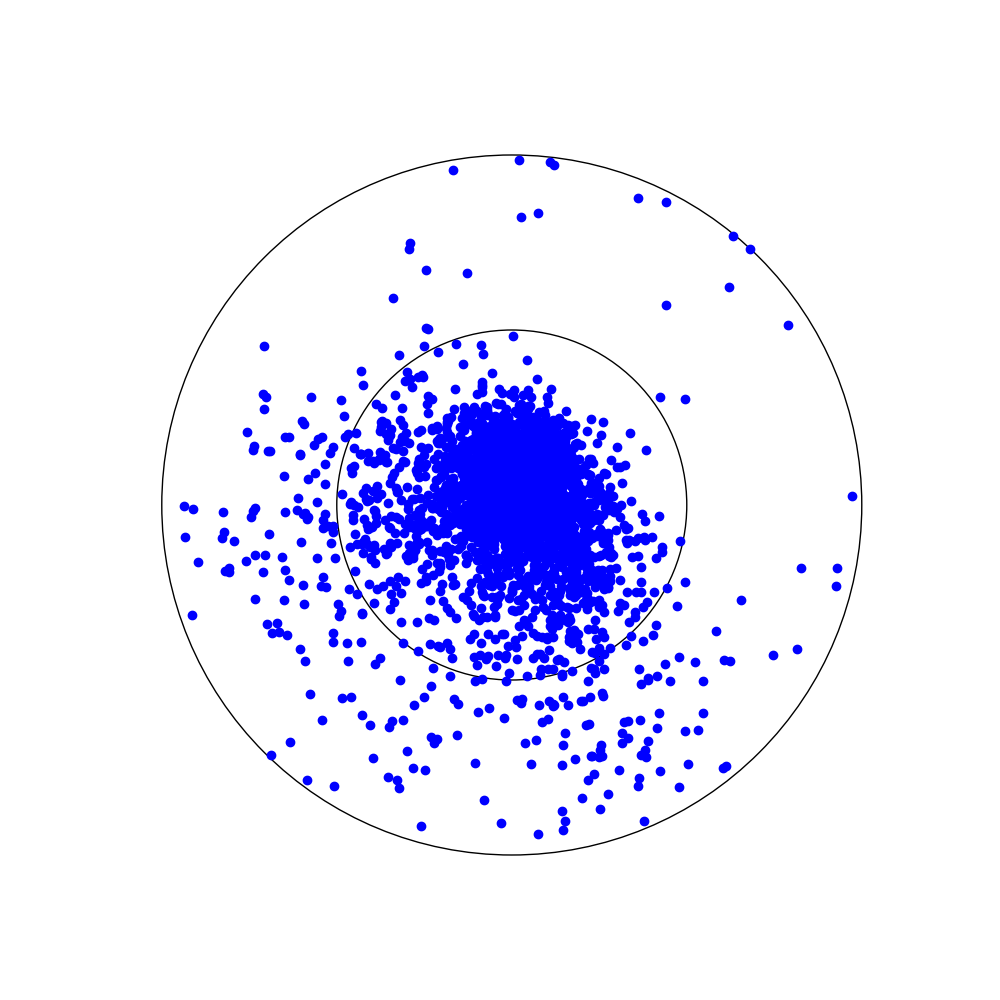

1
2
3
4
5
6
7
8
9
[[ 0.00000000e+00  5.55111512e-17  1.00000000e+00]
 [-7.42803556e-01  5.04940079e-01  4.39634387e-01]
 [ 4.38497160e-01 -7.45824021e-01  5.01464625e-01]
 [-8.61474780e-01 -2.66894712e-01  4.32005112e-01]
 [-1.47373439e-01 -9.77281425e-01  1.52322308e-01]
 [-1.15983632e-01  9.88630482e-01  9.56951838e-02]
 [ 1.54384791e-02 -5.58747766e-01  8.29193938e-01]
 [ 8.87763443e-02  8.67646806e-01 -4.89190945e-01]
 [ 1.75147544e-01  8.11231439e-01 -5.57877129e-01]
 [ 1.03972557e-01  8.11048945e-01 -5.75664239e-01]]


In [23]:
# %matplotlib notebook

# 球体のパラメータ
radius = 1
phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
phi, theta=np.meshgrid(phi, theta)

# 球体の座標を計算
x = radius * np.sin(phi) * np.cos(theta)
y = radius * np.sin(phi) * np.sin(theta)
z = radius * np.cos(phi)


# figureを生成する
fig=plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = fig.add_subplot()
draw_circle_05 = plt.Circle((0, 0), 0.5, fill=False)
draw_circle_1 = plt.Circle((0, 0), 1, fill=False)

ax.set_aspect(1)
ax.add_artist(draw_circle_05)
ax.add_artist(draw_circle_1)



# 詳細の処理

# 重心の算出
for i in range(class_num):
    centroids[i]=caluc_cluster(z_valid_np, y_valid_np, i, class_num)
# 単位球上へ写像
norm_data=norm(z_valid_np)
norm_centroids=norm(centroids)
# データの回転
rotate_centroids_1, theta = caluc_rotation_main(norm_centroids)
rotate_centroids_other = caluc_rotation_sub(norm_centroids, theta)
# ansを合体させる
rotate_centroids=np.zeros((10, 3))
rotate_centroids[0]=rotate_centroids_1
rotate_centroids[1:]=rotate_centroids_other
print(rotate_centroids)
# 他dataの回転→data_projectionの作成
new_data=caluc_rotation_data(norm_data, theta)
data_projection = np.array(new_data, dtype=float)
data_projection=np.transpose(data_projection)

# クラスごとに色を分けてプロット
for i in range(class_num):
    ax.scatter(data_projection[y_valid_np==i, 0], data_projection[y_valid_np==i, 1], color=colors[i], label=class_names[i])
    ax.scatter(rotate_centroids[i, 0], rotate_centroids[i, 1], marker='*', color=colors[i], s=500, linewidths="1", edgecolors="black")
ax.legend()  # 凡例の追加
plt.show()